CTR : Analysis of different ML models


Aim of the notebook.

In this notebook you'll observe the following points addressed.

1. Importance of class balance in classification.
2. Models with and without feature engineering to address the importance of feature engineering.
3. Analysis of different ML models.
4. Importance of cross-validation and maintaining the history.



In [1]:
# Data processing
# ==============================================================================
 
import pandas as pd
import numpy as np
import warnings
import math
import random
import gzip

# Modelling
# ==============================================================================
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from IPython.display import Image  
from six import StringIO
import category_encoders as ce

# Plotting
# ==============================================================================
import seaborn as sns
import matplotlib.pyplot as plt
# import graphviz
warnings.filterwarnings('ignore')
sns.set_theme(style="darkgrid")
pd.set_option('display.max_columns', 0)
plt.style.use('ggplot')
pd.options.display.float_format = '{:.2f}'.format

# Memory Optimization
# ==============================================================================
import gc
gc.collect()

0

Reading input data and basic analysis

In [2]:
# Reading the input data
num_records = 40428967
sample_size = 5000000

# Generate skip values
random.seed(42)  # for reproducibility
skip_values = sorted(random.sample(range(1, num_records + 1), num_records - sample_size))

# Define date parsing function
def parse_date(val):
    return pd.to_datetime(val, format='%y%m%d%H')

# Read the CSV file
train = pd.read_csv(
    "/Users/a81060586/CTR_Predicition/avazu-ctr-prediction/train.gz",
    parse_dates=['hour'],
    date_parser=parse_date,
    skiprows=skip_values
)

# Display the first two rows
print(train.head(2))

                     id  click       hour    C1  ...  C18 C19     C20  C21
0  10000640724480838376      0 2014-10-21  1005  ...    0  35  100084   79
1  10000679056417042096      0 2014-10-21  1005  ...    0  35      -1  157

[2 rows x 24 columns]


In [3]:
# Read the CSV file
test = pd.read_csv(
    "/Users/a81060586/CTR_Predicition/avazu-ctr-prediction/test.gz",
    parse_dates=['hour'],
    date_parser=parse_date,
    skiprows=skip_values
)

# Display the first two rows
print(test.head(2))

                     id       hour    C1  banner_pos  ... C18  C19     C20  C21
0  10001094637809798845 2014-10-31  1005           0  ...   3  809  100156   61
1  10001377041558670745 2014-10-31  1005           0  ...   0   47      -1  221

[2 rows x 23 columns]


In [4]:
# Submission file for final score.
submission = pd.read_csv(
    "/Users/a81060586/CTR_Predicition/avazu-ctr-prediction/sampleSubmission.gz"
)
# Display the first two rows
submission.head(2)

,id,click
0,10000174058809263569,0.50
1,10000182526920855428,0.50


In [5]:
# shape of the data read. 

print('Train dataset:',train.shape)
print('Test dataset:',test.shape)
print('Submission:',submission.shape)

Train dataset: (5000000, 24)
Test dataset: (564540, 23)
Submission: (4577464, 2)


In [6]:
# hour column contains event date with all the details, extracting the same to create different columns.

train['month'] = train['hour'].dt.month
train['dayofweek'] = train['hour'].dt.dayofweek
train['day'] = train['hour'].dt.day
train['hour_time'] = train['hour'].dt.hour
train.head(2)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,month,dayofweek,day,hour_time
0,10000640724480838376,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,e8275b8f,6332421a,1,0,15706,320,50,1722,0,35,100084,79,10,1,21,0
1,10000679056417042096,0,2014-10-21,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,07d7df22,a99f214a,9644d0bf,779d90c2,1,0,18993,320,50,2161,0,35,-1,157,10,1,21,0


In [7]:
# checking the sum of the null values across all cloumns and rows.
train['hour'].isnull().sum().sum()

0

In [8]:
# info on each column of training dataset.
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 28 columns):
 #   Column            Dtype         
---  ------            -----         
 0   id                uint64        
 1   click             int64         
 2   hour              datetime64[ns]
 3   C1                int64         
 4   banner_pos        int64         
 5   site_id           object        
 6   site_domain       object        
 7   site_category     object        
 8   app_id            object        
 9   app_domain        object        
 10  app_category      object        
 11  device_id         object        
 12  device_ip         object        
 13  device_model      object        
 14  device_type       int64         
 15  device_conn_type  int64         
 16  C14               int64         
 17  C15               int64         
 18  C16               int64         
 19  C17               int64         
 20  C18               int64         
 21  C19     

In [9]:
# No null values found in the dataset.
train.isnull().sum()

id                  0
click               0
hour                0
C1                  0
banner_pos          0
site_id             0
site_domain         0
site_category       0
app_id              0
app_domain          0
app_category        0
device_id           0
device_ip           0
device_model        0
device_type         0
device_conn_type    0
C14                 0
C15                 0
C16                 0
C17                 0
C18                 0
C19                 0
C20                 0
C21                 0
month               0
dayofweek           0
day                 0
hour_time           0
dtype: int64

In [10]:
# looks like following columns have outliers  C15, C16, C19, C21. 
train.describe()

,id,click,hour,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,month,dayofweek,day,hour_time
count,5000000.00,5000000.00,5000000,5000000.00,5000000.00,5000000.00,5000000.00,5000000.00,5000000.00,5000000.00,5000000.00,5000000.00,5000000.00,5000000.00,5000000.00,5000000.00,5000000.00,5000000.00,5000000.00
mean,9223662487799631872.00,0.17,2014-10-25 22:34:25.420080640,1004.97,0.29,1.02,0.33,18840.26,318.88,60.11,2112.39,1.43,227.12,53213.40,83.40,10.00,2.60,25.47,11.28
min,2219877217461.00,0.00,2014-10-21 00:00:00,1001.00,0.00,0.00,0.00,375.00,120.00,20.00,112.00,0.00,33.00,-1.00,1.00,10.00,0.00,21.00,0.00
25%,4613991733826280448.00,0.00,2014-10-23 04:00:00,1005.00,0.00,1.00,0.00,16920.00,320.00,50.00,1863.00,0.00,35.00,-1.00,23.00,10.00,1.00,23.00,6.00
50%,9222428605332415488.00,0.00,2014-10-26 02:00:00,1005.00,0.00,1.00,0.00,20346.00,320.00,50.00,2323.00,2.00,39.00,100048.00,61.00,10.00,2.00,26.00,11.00
75%,13833700694095603712.00,0.00,2014-10-28 14:00:00,1005.00,1.00,1.00,0.00,21894.00,320.00,50.00,2526.00,3.00,171.00,100094.00,101.00,10.00,4.00,28.00,16.00
max,18446741921193529344.00,1.00,2014-10-30 23:00:00,1012.00,7.00,5.00,5.00,24052.00,1024.00,1024.00,2758.00,3.00,1839.00,100248.00,255.00,10.00,6.00,30.00,23.00
std,5324875754222224384.00,0.38,NaN,1.09,0.50,0.53,0.85,4962.85,21.24,47.31,609.89,1.33,351.10,49957.07,70.31,0.00,1.73,2.96,5.95


In [11]:
# Dealing with outliers by capping
col = ['C15', 'C16', 'C19', 'C21']
for col in col:
    percentiles = train[col].quantile(0.98)
    if train[col].quantile(0.98) < 0.5 * train[col].max():
        train[col][train[col] >= percentiles] = percentiles

In [12]:
# segrigating numerical and categorical variables.
numerical = []
categorical = []

for col in (train.columns):
    if train[col].dtype == "object":
        categorical.append(col)
    else:
        numerical.append(col)
print("numerical columns = ",numerical)
print("\ncategorical columns = ",categorical)

numerical columns =  ['id', 'click', 'hour', 'C1', 'banner_pos', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'month', 'dayofweek', 'day', 'hour_time']

categorical columns =  ['site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model']


click
0   0.83
1   0.17
Name: proportion, dtype: float64




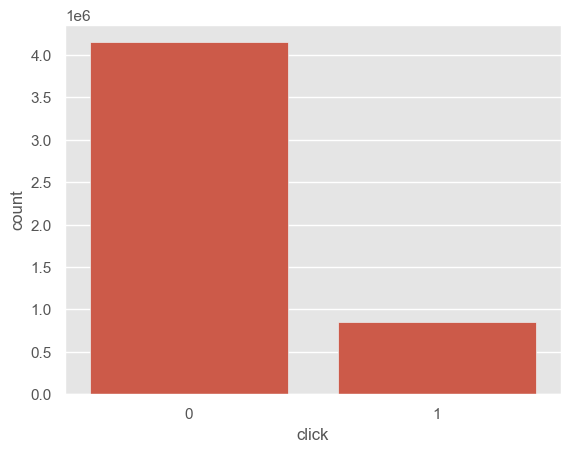

In [13]:
# y is the target variable, analysing the same.
# 83% values are 0 and 17% values are 1. data is highly imbalance. 
print(train.click.value_counts(normalize = True))
print("\n")
plt.figure()
sns.countplot(x='click', data=train)
plt.show()

Analysing categorical variables.

In [14]:
print("unique counts of site_id", len(train['site_id'].unique()))
print("----------------------")
print(train['site_id'].value_counts(normalize = True))

unique counts of site_id 3515
----------------------
site_id
85f751fd   0.36
1fbe01fe   0.16
e151e245   0.07
d9750ee7   0.02
5b08c53b   0.02
           ... 
182b15ce   0.00
f392c0c1   0.00
bb6435db   0.00
fa6dfd7d   0.00
f7fd11d6   0.00
Name: proportion, Length: 3515, dtype: float64


In [15]:
print("unique counts of site_domain", len(train['site_domain'].unique()))
print("----------------------")
print(train['site_domain'].value_counts(normalize = True))

unique counts of site_domain 4506
----------------------
site_domain
c4e18dd6   0.37
f3845767   0.16
7e091613   0.08
7687a86e   0.03
98572c79   0.02
           ... 
3b25d7ed   0.00
f9ee9a0e   0.00
2c213a15   0.00
a6aee6af   0.00
df5df967   0.00
Name: proportion, Length: 4506, dtype: float64


In [16]:
print("unique counts of site_category", len(train['site_category'].unique()))
print("----------------------")
print(train['site_category'].value_counts(normalize = True))

unique counts of site_category 23
----------------------
site_category
50e219e0   0.41
f028772b   0.31
28905ebd   0.18
3e814130   0.08
f66779e6   0.01
75fa27f6   0.00
335d28a8   0.00
76b2941d   0.00
c0dd3be3   0.00
72722551   0.00
dedf689d   0.00
70fb0e29   0.00
0569f928   0.00
8fd0aea4   0.00
a818d37a   0.00
42a36e14   0.00
e787de0e   0.00
bcf865d9   0.00
5378d028   0.00
9ccfa2ea   0.00
c706e647   0.00
da34532e   0.00
74073276   0.00
Name: proportion, dtype: float64


In [17]:
print("unique counts of app_id", len(train['app_id'].unique()))
print("----------------------")
print(train['app_id'].value_counts(normalize = True))

unique counts of app_id 5209
----------------------
app_id
ecad2386   0.64
92f5800b   0.04
e2fcccd2   0.03
9c13b419   0.02
febd1138   0.02
           ... 
d4546f0f   0.00
5423b77e   0.00
bde92465   0.00
6bceaf84   0.00
af3f2d83   0.00
Name: proportion, Length: 5209, dtype: float64


In [18]:
print("unique counts of app_domain", len(train['app_domain'].unique()))
print("----------------------")
print(train['app_domain'].value_counts(normalize = True))

unique counts of app_domain 331
----------------------
app_domain
7801e8d9   0.67
2347f47a   0.13
ae637522   0.05
5c5a694b   0.03
82e27996   0.02
           ... 
ee7d2e2b   0.00
e25eea83   0.00
ff191ca9   0.00
438468ad   0.00
d95432fe   0.00
Name: proportion, Length: 331, dtype: float64


In [19]:
print("unique counts of app_category", len(train['app_category'].unique()))
print("----------------------")
print(train['app_category'].value_counts(normalize = True))

unique counts of app_category 29
----------------------
app_category
07d7df22   0.65
0f2161f8   0.24
cef3e649   0.04
8ded1f7a   0.04
f95efa07   0.03
d1327cf5   0.00
dc97ec06   0.00
09481d60   0.00
75d80bbe   0.00
fc6fa53d   0.00
4ce2e9fc   0.00
879c24eb   0.00
a3c42688   0.00
4681bb9d   0.00
0f9a328c   0.00
a86a3e89   0.00
2281a340   0.00
8df2e842   0.00
79f0b860   0.00
0bfbc358   0.00
a7fd01ec   0.00
7113d72a   0.00
18b1e0be   0.00
2fc4f2aa   0.00
5326cf99   0.00
bd41f328   0.00
0d82db25   0.00
6fea3693   0.00
71af18ce   0.00
Name: proportion, dtype: float64


In [20]:
print("unique counts of device_id", len(train['device_id'].unique()))
print("----------------------")
print(train['device_id'].value_counts(normalize = True))

unique counts of device_id 599079
----------------------
device_id
a99f214a   0.83
0f7c61dc   0.00
c357dbff   0.00
936e92fb   0.00
afeffc18   0.00
           ... 
1b6f68d9   0.00
8716ceff   0.00
993da876   0.00
bc04a1bb   0.00
2bdd5fec   0.00
Name: proportion, Length: 599079, dtype: float64


In [21]:
print("unique counts of device_ip", len(train['device_ip'].unique()))
print("----------------------")
print(train['device_ip'].value_counts(normalize = True))

unique counts of device_ip 1904514
----------------------
device_ip
6b9769f2   0.01
431b3174   0.00
2f323f36   0.00
af9205f9   0.00
af62faf4   0.00
           ... 
2c10c7da   0.00
629dcdfc   0.00
cd6af03b   0.00
e56bf99a   0.00
35bef956   0.00
Name: proportion, Length: 1904514, dtype: float64


In [22]:
print("unique counts of device_model", len(train['device_model'].unique()))
print("----------------------")
print(train['device_model'].value_counts(normalize = True))

unique counts of device_model 6536
----------------------
device_model
8a4875bd   0.06
1f0bc64f   0.04
d787e91b   0.03
76dc4769   0.02
be6db1d7   0.02
           ... 
02c86868   0.00
d5b6d478   0.00
a61efb66   0.00
85d5bee9   0.00
8f8389fc   0.00
Name: proportion, Length: 6536, dtype: float64


Observations :

- All categorical variables have lot of unique values in it, one hot encoding is not a scalable approach.
- We will go with label encoding and scaling approach is a better idea for this.

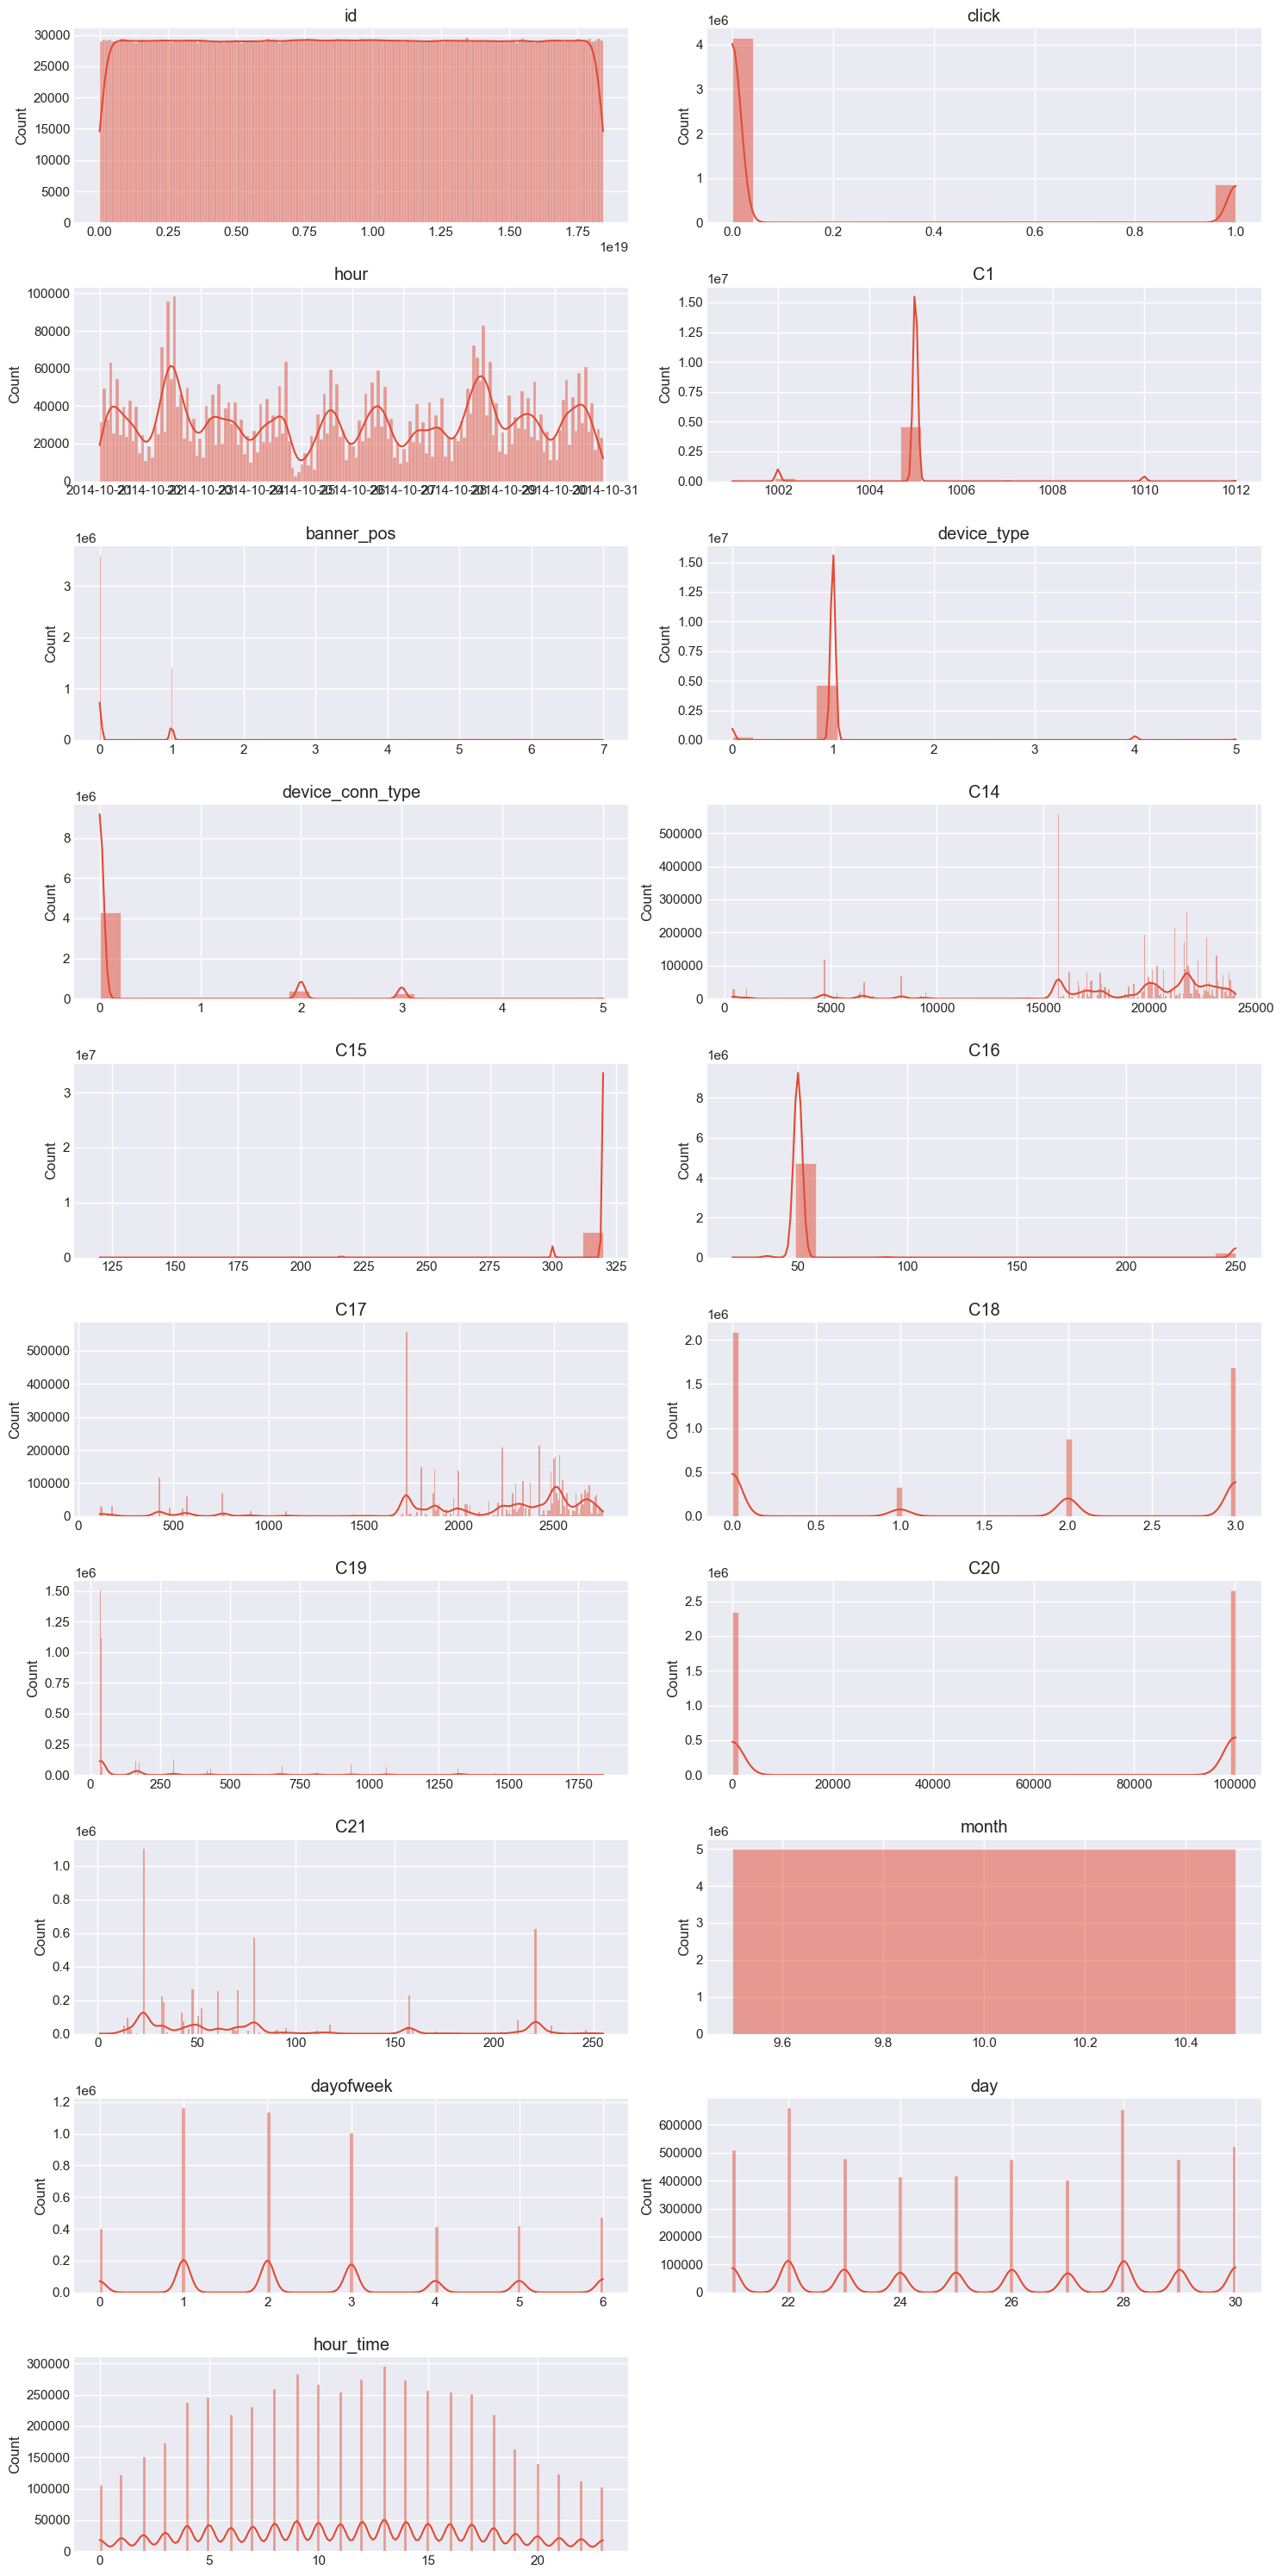

In [23]:
# Set the style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')  # Updated style name

# The number of columns in the subplot grid
n = 2

# Calculate the number of rows needed
num_rows = math.ceil(len(numerical) / n)

# Create the figure and subplots
fig, axes = plt.subplots(num_rows, n, figsize=(15, 3 * num_rows))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot histograms for all numerical columns
for i, col in enumerate(numerical):
    sns.histplot(data=train, x=col, kde=True, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('')  # Remove x-label as it's redundant with the title

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

Observations : 

- Y and Click looks like same columns, after co-relation we can drop on of them.
- month column has only 1 data entry, no exrtra information is added, can be dropped
- banner pos, device conn, C20, C15, C16 looks like data is cenetered around certain values.

In [24]:
train.columns

Index(['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'month', 'dayofweek',
       'day', 'hour_time'],
      dtype='object')

In [25]:
# as said above dropping columns. 
train.drop(['month', 'C20'], axis=1, inplace=True)
train.columns

Index(['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C21', 'dayofweek', 'day',
       'hour_time'],
      dtype='object')

In [26]:
"""
# Pearson correlation table to find the relationship with output with all input features. 

corr = train.corr()
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, ax=ax, annot=True,linewidths=3,cmap='YlGn')
plt.title("Pearson correlation of Features", y=1.05, size=15)
"""

ValueError: could not convert string to float: '1fbe01fe'

Observation: 

- month has got no significance, better to drop it
- y and click are same drop click column
- C14 and C17 are highly co-related, later will remove one of them after the base model.
- device type with C1 are highly co-related, later will remove one of them after the base model.
- Removing C20 anomalised column, since it have got nearly 47% of values with -1. As a categorical variable it's not expected to have values as -1.

Data preperation

In [27]:
# id column have a unique columns so, keeping that don't provide any significance,hence dropping.
# hour column have been derived into different columns, hence dropping. 
# rename click to y (output)
# after dropping hour column, hour_time can be made as hour

train.drop(['id', 'hour'], axis = 1, inplace = True) 
train.rename(columns={'click': 'y',
                   'hour_time': 'hour'},
          inplace=True, errors='raise')

train.columns

Index(['y', 'C1', 'banner_pos', 'site_id', 'site_domain', 'site_category',
       'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip',
       'device_model', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16',
       'C17', 'C18', 'C19', 'C21', 'dayofweek', 'day', 'hour'],
      dtype='object')

In [28]:
# dataset is huge and running multiple algo will take time and resources might exhaust, 
# hence taking only 10% of the data for analysis.

sampled_data = train.sample(frac=0.1, random_state=42)
X = sampled_data.drop(['y'], axis=1)
y = sampled_data['y']

y
0   0.83
1   0.17
Name: proportion, dtype: float64




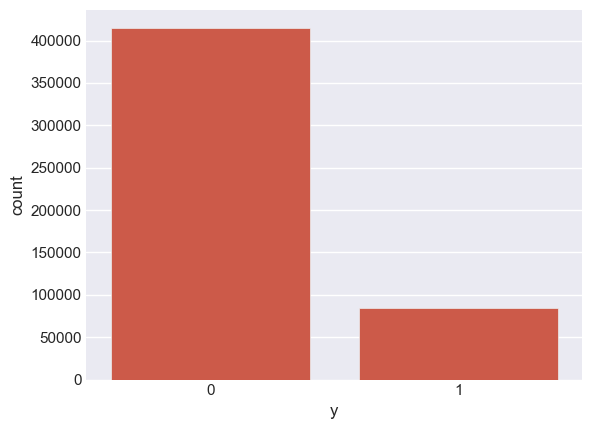

In [29]:
# After taking the sample of data, still the ratio of output remains same.

print(train.y.value_counts(normalize = True))
print("\n")
plt.figure()
sns.countplot(x=y)
plt.show()

In [30]:
target_encoder = ce.TargetEncoder()
X = target_encoder.fit_transform(X, y)
X.head(2)

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
3577888,1005,0,0.12,0.12,0.13,0.07,0.14,0.09,0.17,0.15,0.08,1,3,23144,320,50,2665,0,35,221,1,28,10
4993932,1005,0,0.12,0.12,0.13,0.05,0.14,0.11,0.17,0.14,0.13,1,2,22792,320,50,2644,3,35,23,3,30,23


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size= 0.3, random_state= 42)

Building basic models [no feature engineering] : 

- in this no feature engineering is done apart from removing definate columns click and month.
- We will run 3 models a. Logistic regression [for explainability and finding linear relationship] b. Decision tree classifier [for explainability and also for non-linear relation] c. Random forest classifier [for accuracy and improving the model]
- Target variable is highly imbalance, so model will be baised towards majority class. for every base model will try with both balance and imbalance data.

defining functions for later use

In [32]:
# this function helps in evaluation the given model and provide accuracy and confusion matrix. 

def model_eval(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    #print(accuracy)
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    #print(cnf_matrix)
    #metrics.plot_confusion_matrix(model, X_test, y_test)
    #plt.show()
    return accuracy, cnf_matrix

In [33]:
# Plots the ROC curve and returns false positive rate, true positive rate, and thresholds. 

def draw_roc(model, Xtest, actual):
    probs = model.predict(X_test)
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

In [34]:
# Returns the crossvalidation score for given number of n folds. 

def cross_val (model, x, y, folds):
    crossvalidation = cross_val_score(model, x, y, cv= folds, n_jobs=-1)
    return crossvalidation

In [35]:

def store_results(name, ytrain, xtrain, ytest, xtest, model, folds):
    
    crossvalidation = cross_val(model, xtrain, ytrain, folds)
    
    accuracy_test, cm1 =  model_eval(model, xtrain, ytrain)
    TP = cm1[1,1] # true positive 
    TN = cm1[0,0] # true negatives
    FP = cm1[0,1] # false positives
    FN = cm1[1,0] # false negatives
    recall_test = TP / (TP+FP)
    precision_test = TP / (TP+FN)
    
    accuracy_train, cm1 =  model_eval(model, xtest, ytest)
    TP = cm1[1,1] # true positive 
    TN = cm1[0,0] # true negatives
    FP = cm1[0,1] # false positives
    FN = cm1[1,0] # false negatives
    recall_train = TP / (TP+FP)
    precision_train = TP / (TP+FN)

    entry = {'Model': [name],
          'Accuracy_train': [accuracy_train],
          'recall_train': [recall_train],
          'precision_train': [precision_train],
          'Accuracy_test': [accuracy_train],
          'recall_test': [recall_train],
          'precision_test': [precision_train],
          'CrossVal_Mean': [crossvalidation.mean()],           
          'CrossVal1': [crossvalidation[0]],
          'CrossVal2': [crossvalidation[1]],
          'CrossVal3': [crossvalidation[2]],
          'CrossVal4': [crossvalidation[3]],
          'CrossVal5': [crossvalidation[4]],
          }
    result = pd.DataFrame(entry)
    return result

Dummy classifier for verification

Dummy classifier helps in baseling the model performace w.r.t dominanat class.

In [36]:
outcome = pd.DataFrame()
dummy_clf = DummyClassifier(strategy= "most_frequent")
dummy_clf.fit(X_train, y_train)
accuracy, cnf_matrix  = model_eval(dummy_clf, X_train, y_train)
print(accuracy)
print(cnf_matrix)
temp = store_results("Dummy classifier", y_train, X_train, y_test, X_test, dummy_clf, 5)
outcome = pd.concat([outcome, temp])
outcome

0.8307285714285715
[[290755      0]
 [ 59245      0]]


,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy classifier,0.83,NaN,0.00,0.83,NaN,0.00,0.83,0.83,0.83,0.83,0.83,0.83


Basic regression model with imbalance predictor

In [37]:
X_train.head()

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
3485624,1005,0,0.21,0.21,0.21,0.20,0.19,0.20,0.17,0.22,0.22,1,0,20108,320,50,2299,2,1327,52,1,28,7
3752708,1005,1,0.24,0.24,0.18,0.20,0.19,0.20,0.17,0.19,0.27,1,0,23424,216,36,2683,1,163,212,1,28,14
955034,1005,1,0.08,0.08,0.21,0.20,0.19,0.20,0.17,0.17,0.21,1,0,15707,320,50,1722,0,35,79,2,22,13
4270460,1005,0,0.16,0.16,0.28,0.20,0.19,0.20,0.17,0.28,0.22,1,0,17239,320,50,1973,3,39,23,2,29,12
1183911,1005,1,0.30,0.26,0.18,0.20,0.19,0.20,0.17,0.15,0.20,1,0,17037,320,50,1934,2,39,16,3,23,1


In [38]:
scaler = MinMaxScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_train.head()

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
3485624,0.36,0.00,0.26,0.30,0.38,0.20,0.35,0.77,0.21,0.32,0.36,0.20,0.00,0.83,1.00,0.13,0.83,0.67,0.72,0.20,0.17,0.78,0.30
3752708,0.36,0.14,0.30,0.35,0.32,0.20,0.35,0.77,0.21,0.27,0.43,0.20,0.00,0.97,0.48,0.07,0.97,0.33,0.07,0.83,0.17,0.78,0.61
955034,0.36,0.14,0.10,0.12,0.38,0.20,0.35,0.77,0.21,0.26,0.34,0.20,0.00,0.65,1.00,0.13,0.61,0.00,0.00,0.31,0.33,0.11,0.57
4270460,0.36,0.00,0.20,0.23,0.52,0.20,0.35,0.77,0.21,0.41,0.36,0.20,0.00,0.71,1.00,0.13,0.70,1.00,0.00,0.09,0.33,0.89,0.52
1183911,0.36,0.14,0.37,0.38,0.32,0.20,0.35,0.77,0.21,0.22,0.33,0.20,0.00,0.70,1.00,0.13,0.69,0.67,0.00,0.06,0.50,0.22,0.04


In [39]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [40]:
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])
X_test.head(2)

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
2780526,0.36,0.14,0.16,0.20,0.32,0.20,0.35,0.77,0.21,0.22,0.30,0.20,0.00,0.34,1.00,0.13,0.25,1.00,0.08,0.09,1.00,0.56,0.61
3708186,0.36,0.14,0.40,0.46,0.32,0.20,0.35,0.77,0.21,0.29,0.28,0.20,0.00,0.97,1.00,0.13,0.97,0.67,0.14,0.20,0.17,0.78,0.57


In [41]:
y_pred = model.predict(X_test)
accuracy, cnf_matrix = model_eval(model, X_test, y_test)
print(accuracy)
print(cnf_matrix)
temp = store_results("logistic regres - imbalance predict", y_train, X_train, y_test, X_test, model, 5)
outcome = pd.concat([outcome, temp])
outcome

0.9285733333333334
[[121343   3266]
 [  7448  17943]]


,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy classifier,0.83,NaN,0.00,0.83,NaN,0.00,0.83,0.83,0.83,0.83,0.83,0.83
0,logistic regres - imbalance predict,0.93,0.85,0.71,0.93,0.85,0.71,0.93,0.93,0.93,0.93,0.93,0.93


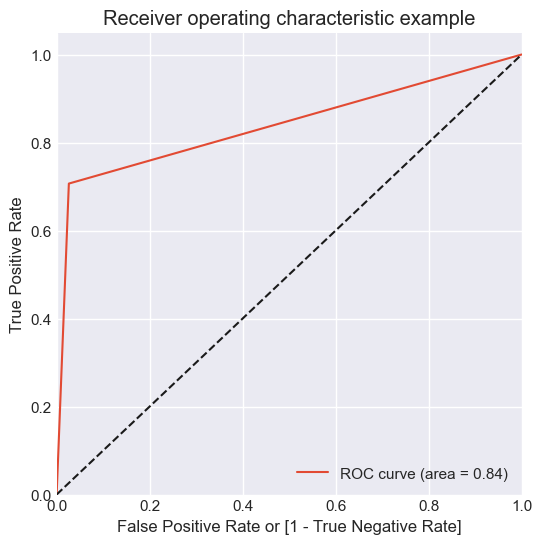

(array([0.        , 0.02620998, 1.        ]),
 array([0.        , 0.70666772, 1.        ]),
 array([inf,  1.,  0.]))

In [42]:
draw_roc(model, X_test, y_test)

Observation : 

- Logistic regression is behaving better than dummy classifier.
- ROC_AUC is doing better at all

Basic regression model with balance predictor

Original dataset shape  Counter({0: 415364, 1: 84636})
Resampled dataset shape Counter({0: 415364, 1: 415364})


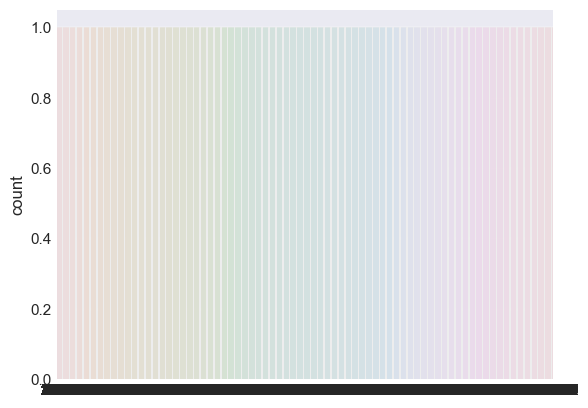

In [43]:
# x_new and y_new we will use for balanced data set for all modules
randomsample=  RandomOverSampler()
x_new, y_new = randomsample.fit_resample(X, y)

from collections import Counter
print('Original dataset shape  {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_new)))
sns.countplot(y_new, palette='husl')
plt.show()

In [44]:
x_new.head(2)

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
0,1005,0,0.12,0.12,0.13,0.07,0.14,0.09,0.17,0.15,0.08,1,3,23144,320,50,2665,0,35,221,1,28,10
1,1005,0,0.12,0.12,0.13,0.05,0.14,0.11,0.17,0.14,0.13,1,2,22792,320,50,2644,3,35,23,3,30,23


In [45]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y_new, stratify= y_new, test_size= 0.3, random_state= 42)

In [46]:
scaler = MinMaxScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_train.head(2)

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
155724,0.36,0.00,0.15,0.18,0.21,0.05,0.09,0.37,0.21,0.21,0.12,0.20,0.00,0.85,1.00,0.13,0.85,1.00,0.07,0.24,0.50,1.00,0.52
374019,0.09,0.00,0.17,0.20,0.21,0.20,0.35,0.77,0.18,0.25,0.38,0.00,0.00,0.66,1.00,0.13,0.62,1.00,0.15,0.32,0.67,0.33,0.57


In [47]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

0.8921992303957563
[[112662  11948]
 [ 14918 109691]]


/Users/a81060586/anaconda3/envs/gp_ecomm/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/a81060586/anaconda3/envs/gp_ecomm/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

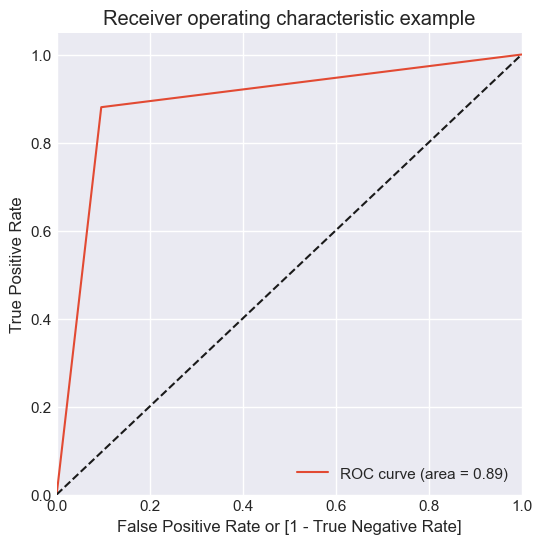

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy classifier,0.83,NaN,0.00,0.83,NaN,0.00,0.83,0.83,0.83,0.83,0.83,0.83
0,logistic regres - imbalance predict,0.93,0.85,0.71,0.93,0.85,0.71,0.93,0.93,0.93,0.93,0.93,0.93
0,logistic regres - balance predict,0.89,0.90,0.88,0.89,0.90,0.88,0.89,0.89,0.89,0.89,0.89,0.89


In [48]:
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])
y_pred = model.predict(X_test)
accuracy, cnf_matrix = model_eval(model, X_test, y_test)
print(accuracy)
print(cnf_matrix)
temp = store_results("logistic regres - balance predict", y_train, X_train, y_test, X_test, model, 5)
draw_roc(model, X_test, y_test)
outcome = pd.concat([outcome, temp])
outcome

Decision tree classifier with unbalanced data

In [49]:
# decision tree doesn't require feature scaling, will use the raw features directly 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size= 0.3, random_state= 42)
X_train.head(2)

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
3485624,1005,0,0.21,0.21,0.21,0.20,0.19,0.20,0.17,0.22,0.22,1,0,20108,320,50,2299,2,1327,52,1,28,7
3752708,1005,1,0.24,0.24,0.18,0.20,0.19,0.20,0.17,0.19,0.27,1,0,23424,216,36,2683,1,163,212,1,28,14


0.9150733333333333
[[118200   6409]
 [  6330  19061]]


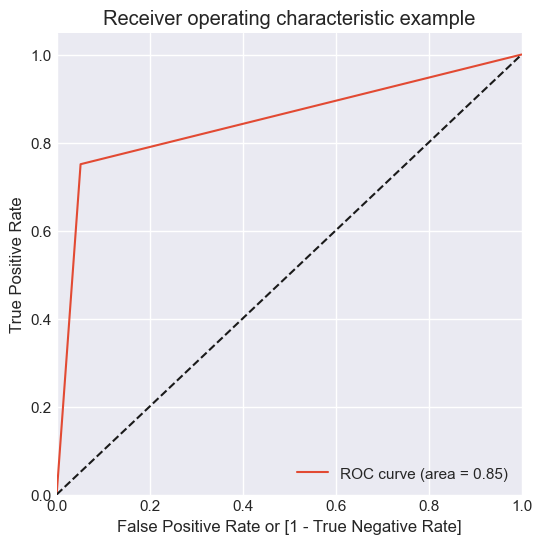

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy classifier,0.83,NaN,0.00,0.83,NaN,0.00,0.83,0.83,0.83,0.83,0.83,0.83
0,logistic regres - imbalance predict,0.93,0.85,0.71,0.93,0.85,0.71,0.93,0.93,0.93,0.93,0.93,0.93
0,logistic regres - balance predict,0.89,0.90,0.88,0.89,0.90,0.88,0.89,0.89,0.89,0.89,0.89,0.89
0,decision tree basic - imbalance predict,0.92,0.75,0.75,0.92,0.75,0.75,0.91,0.91,0.91,0.91,0.91,0.91


In [50]:
dt_basic = DecisionTreeClassifier(random_state=42)
dt_basic.fit(X_train, y_train)
y_preds = dt_basic.predict(X_test)
accuracy, cnf_matrix = model_eval(dt_basic, X_test, y_test)
print(accuracy)
print(cnf_matrix)
temp = store_results("decision tree basic - imbalance predict", y_train, X_train, y_test, X_test, dt_basic, 5)
draw_roc(dt_basic, X_test, y_test)
outcome = pd.concat([outcome, temp])
outcome

Observation : 

- decision tree on unbalanced data isn't doing that great.
- decision tree on balanced data is really doing very good.
- decision tree on balanced data on test data as well as cross validation is doing really well.
- ROC_AUC curve looks really good.

Random forest classifier with imbalanced dat

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size= 0.3, random_state= 42)
X_train.head(2)

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
3485624,1005,0,0.21,0.21,0.21,0.20,0.19,0.20,0.17,0.22,0.22,1,0,20108,320,50,2299,2,1327,52,1,28,7
3752708,1005,1,0.24,0.24,0.18,0.20,0.19,0.20,0.17,0.19,0.27,1,0,23424,216,36,2683,1,163,212,1,28,14


0.9313933333333333
[[121552   3057]
 [  7234  18157]]


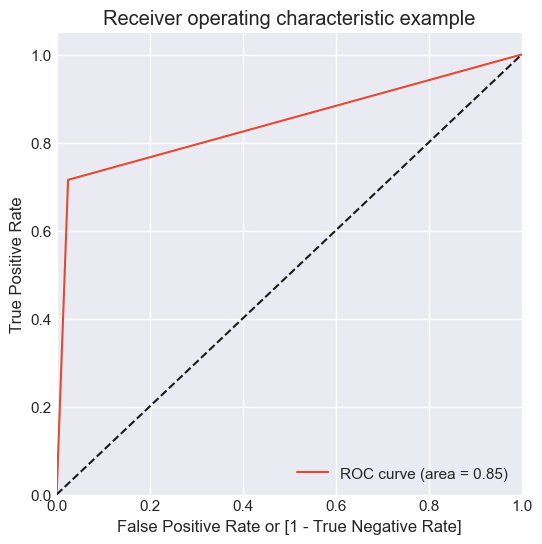

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy classifier,0.83,NaN,0.00,0.83,NaN,0.00,0.83,0.83,0.83,0.83,0.83,0.83
0,logistic regres - imbalance predict,0.93,0.85,0.71,0.93,0.85,0.71,0.93,0.93,0.93,0.93,0.93,0.93
0,logistic regres - balance predict,0.89,0.90,0.88,0.89,0.90,0.88,0.89,0.89,0.89,0.89,0.89,0.89
0,decision tree basic - imbalance predict,0.92,0.75,0.75,0.92,0.75,0.75,0.91,0.91,0.91,0.91,0.91,0.91
0,Random forest basic - imbalance predict,0.93,0.86,0.72,0.93,0.86,0.72,0.93,0.93,0.93,0.93,0.93,0.93


In [52]:
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)
y_preds = model_rf.predict(X_test)
accuracy, cnf_matrix = model_eval(model_rf, X_test, y_test)
print(accuracy)
print(cnf_matrix)
temp = store_results("Random forest basic - imbalance predict", y_train, X_train, y_test, X_test, model_rf, 5)
draw_roc(model_rf, X_test, y_test)
outcome = pd.concat([outcome, temp])
outcome

Random forest classifier with balanced data

In [53]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y_new, stratify= y_new, test_size= 0.3, random_state= 42)
X_train.head(2)

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
155724,1005,0,0.12,0.12,0.13,0.05,0.05,0.11,0.17,0.15,0.08,1,0,20508,320,50,2351,3,163,61,3,30,12
374019,1002,0,0.14,0.14,0.13,0.20,0.19,0.20,0.15,0.17,0.23,0,0,15908,320,50,1752,3,297,82,4,24,13


0.9645693145386186
[[116703   7907]
 [   923 123686]]


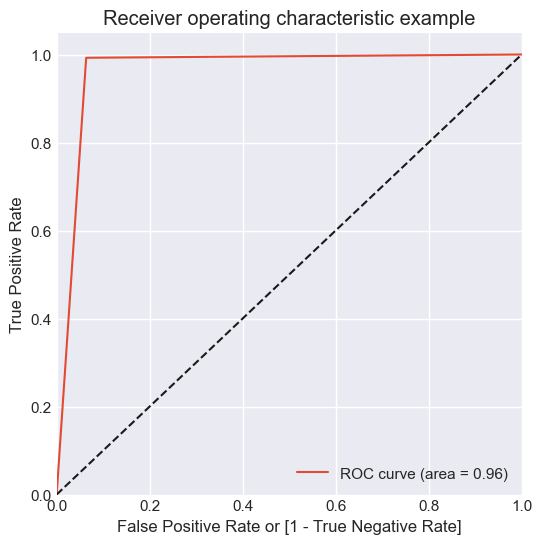

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy classifier,0.83,NaN,0.00,0.83,NaN,0.00,0.83,0.83,0.83,0.83,0.83,0.83
0,logistic regres - imbalance predict,0.93,0.85,0.71,0.93,0.85,0.71,0.93,0.93,0.93,0.93,0.93,0.93
0,logistic regres - balance predict,0.89,0.90,0.88,0.89,0.90,0.88,0.89,0.89,0.89,0.89,0.89,0.89
0,decision tree basic - imbalance predict,0.92,0.75,0.75,0.92,0.75,0.75,0.91,0.91,0.91,0.91,0.91,0.91
0,Random forest basic - imbalance predict,0.93,0.86,0.72,0.93,0.86,0.72,0.93,0.93,0.93,0.93,0.93,0.93
0,Random forest basic - balance predict,0.96,0.94,0.99,0.96,0.94,0.99,0.96,0.96,0.96,0.96,0.96,0.96


In [54]:
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)
y_preds = model_rf.predict(X_test)
accuracy, cnf_matrix = model_eval(model_rf, X_test, y_test)
print(accuracy)
print(cnf_matrix)
temp = store_results("Random forest basic - balance predict", y_train, X_train, y_test, X_test, model_rf, 5)
draw_roc(model_rf, X_test, y_test)
outcome = pd.concat([outcome, temp])
outcome

Observation :

- Random forest data with imbalance data is over fitted for training data.
- Random forest with balanced data set is performing the best so far on both train and test data.
- Random forest with balanced data holding good for cross validation as well. Conclusion based on simple models built :- Random forest on balanced data set is the best model built

In [55]:
data_feature = sampled_data.copy()

In [57]:
"""
corr = data_feature.corr()
f, ax = plt.subplots(figsize=(12,12))
sns.heatmap(corr, ax=ax, annot=True, linewidths=5,cmap='YlGn')
plt.title("Pearson correlation of Features", y=1.05, size=15)
"""

'\ncorr = data_feature.corr()\nf, ax = plt.subplots(figsize=(12,12))\nsns.heatmap(corr, ax=ax, annot=True, linewidths=5,cmap=\'YlGn\')\nplt.title("Pearson correlation of Features", y=1.05, size=15)\n'

In [58]:
# C1 and device_type are highly corelated, since C1 is anomalised column we can drop it.
# C14 and C17 are highly co-related, dropping either is a good idea.

data_feature.drop(['C14', 'C1'], axis=1, inplace= True)

In [59]:
X = data_feature.drop(['y'], axis=1)
y = data_feature['y']

In [60]:
target_encoder = ce.TargetEncoder()
X = target_encoder.fit_transform(X, y)
X.head(2)

,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
3577888,0,0.12,0.12,0.13,0.07,0.14,0.09,0.17,0.15,0.08,1,3,320,50,2665,0,35,221,1,28,10
4993932,0,0.12,0.12,0.13,0.05,0.14,0.11,0.17,0.14,0.13,1,2,320,50,2644,3,35,23,3,30,23


Original dataset shape  Counter({0: 415364, 1: 84636})
Resampled dataset shape Counter({0: 415364, 1: 415364})


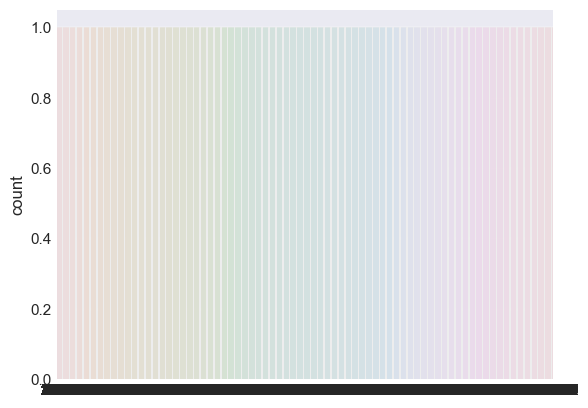

In [61]:
# As discussed at the start, we will use balanced data for all the 
# x_new and y_new we will use for balanced data set for all modules
randomsample=  RandomOverSampler()
x_new, y_new = randomsample.fit_resample(X, y)

from collections import Counter
print('Original dataset shape  {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_new)))
sns.countplot(y_new, palette='husl')
plt.show()

In [62]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y_new, stratify= y_new, test_size= 0.3, random_state= 42)

Logistic regression model with feature engineering and balance predictor.

In [63]:
scaler = MinMaxScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_train.head()

,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
155724,0.00,0.15,0.18,0.21,0.05,0.09,0.37,0.21,0.21,0.12,0.20,0.00,1.00,0.13,0.85,1.00,0.07,0.24,0.50,1.00,0.52
374019,0.00,0.17,0.20,0.21,0.20,0.35,0.77,0.18,0.25,0.38,0.00,0.00,1.00,0.13,0.62,1.00,0.15,0.32,0.67,0.33,0.57
532713,0.00,0.16,0.18,0.32,0.20,0.35,0.77,0.21,0.41,0.27,0.20,0.00,1.00,0.13,0.90,0.00,0.00,0.87,0.33,0.11,0.48
560147,0.14,0.30,0.35,0.32,0.20,0.35,0.77,0.21,0.26,0.52,0.20,0.00,1.00,0.13,0.98,1.00,0.01,0.09,0.33,0.89,0.87
752570,0.00,0.15,0.18,0.21,0.20,0.33,0.31,0.34,0.41,0.30,0.20,0.00,1.00,0.13,0.02,1.00,0.72,0.06,0.17,0.00,0.52


In [64]:
X_train_sm = sm.add_constant(X_train)
logm2 = sm.GLM(y_train, X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:               581509
Model:                            GLM   Df Residuals:                   581487
Model Family:                Binomial   Df Model:                           21
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.5638e+05
Date:                Sun, 08 Sep 2024   Deviance:                   3.1275e+05
Time:                        10:13:49   Pearson chi2:                 2.03e+14
No. Iterations:                    10   Pseudo R-squ. (CS):             0.5719
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -21.9237      0.168   -130.321      0.000     -22.253     -21.594
banner_pos           0.8470      0.081     10.499      0.000       0.689       1.005
site_id             -9.6996      0.118    -82.144      0.000      -9.931      -9.468
site_domain         12.7951      0.112    113.827      0.000      12.575      13.015
site_category        1.5517      0.075     20.794      0.000       1.405       1.698
app_id               7.4353      0.151     49.392      0.000       7.140       7.730
app_domain          -3.1408      0.108    -29.116      0.000      -3.352      -2.929
app_category        -1.0754      0.044    -24.176      0.000      -1.163      -0.988
device_id           50.1573      0.545     91.990      0.000      49.089      51.226
device_ip           29.4252      0.080    366.408      0.000      29.268      29.583
device_model         0.3079      0.058      5.310      0.000       0.194       0.422
device_type          0.1732      0.105      1.648      0.099      -0.033       0.379
device_conn_type     0.0656      0.040      1.635      0.102      -0.013       0.144
C15                  1.5676      0.108     14.469      0.000       1.355       1.780
C16                 -0.7793      0.033    -23.422      0.000      -0.845      -0.714
C17                  0.0867      0.026      3.372      0.001       0.036       0.137
C18                 -0.1000      0.014     -7.232      0.000      -0.127      -0.073
C19                  0.5106      0.024     20.980      0.000       0.463       0.558
C21                 -0.2313      0.022    -10.322      0.000      -0.275      -0.187
dayofweek           -0.0137      0.016     -0.847      0.397      -0.045       0.018
day                 -0.0657      0.015     -4.475      0.000      -0.094      -0.037
hour                -0.2613      0.018    -14.498      0.000      -0.297      -0.226
====================================================================================
"""

In [65]:
y_train_pred = res.predict(X_train_sm)
y_train_pred_final = pd.DataFrame({'y':y_train, 'y_Prob':y_train_pred})
y_train_pred_final['predicted'] = y_train_pred_final.y_Prob.map(lambda x: 1 if x > 0.5 else 0)
confusion = metrics.confusion_matrix(y_train_pred_final.y, y_train_pred_final.predicted )
print(confusion)
print(metrics.accuracy_score(y_train_pred_final.y, y_train_pred_final.predicted))

[[262763  27991]
 [ 34719 256036]]
0.8921598805865429


In [66]:
def sm_model_evaluation (model, x_test, y_test):
    '''
    model = sm model
    y_test = series of labels 
    columns = list of columns in features
    x_test = test dataframe 
    '''
    X_sm = sm.add_constant(x_test)
    y_pred = res.predict(X_sm)
    y_train_pred_final = pd.DataFrame({'y':y_test, 'y_Prob':y_pred})
    y_train_pred_final['predicted'] = y_train_pred_final.y_Prob.map(lambda x: 1 if x > 0.5 else 0)
    # Let's check the overall accuracy.
    print(metrics.accuracy_score(y_train_pred_final.y, y_train_pred_final.predicted))
    confusion = metrics.confusion_matrix(y_train_pred_final.y, y_train_pred_final.predicted )
    print(confusion)

In [67]:
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])
sm_model_evaluation(res, X_test, y_test)  

0.8932103892560359
[[112673  11937]
 [ 14677 109932]]


In [68]:
vif = pd.DataFrame()
vif['Features'] = X_train_sm.columns
vif['VIF'] = [variance_inflation_factor(X_train_sm.values, i) for i in range(X_train_sm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,624.94
2,site_id,8.28
3,site_domain,8.24
7,app_category,2.31
6,app_domain,2.22
5,app_id,2.18
14,C16,2.14
4,site_category,2.04
18,C21,1.77
16,C18,1.63


In [69]:
# VIF looks good, w.r.t P values hour and dayofweek have got highest, will remove and build the model.

X_train_sm.drop(['hour','day'], axis=1, inplace= True)
logm2 = sm.GLM(y_train, X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:               581509
Model:                            GLM   Df Residuals:                   581489
Model Family:                Binomial   Df Model:                           19
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.5650e+05
Date:                Sun, 08 Sep 2024   Deviance:                   3.1299e+05
Time:                        10:14:02   Pearson chi2:                 2.12e+14
No. Iterations:                    10   Pseudo R-squ. (CS):             0.5718
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -22.0700      0.168   -131.441      0.000     -22.399     -21.741
banner_pos           0.8546      0.081     10.593      0.000       0.696       1.013
site_id             -9.7333      0.118    -82.414      0.000      -9.965      -9.502
site_domain         12.7930      0.112    113.776      0.000      12.573      13.013
site_category        1.5655      0.075     20.961      0.000       1.419       1.712
app_id               7.3775      0.151     48.997      0.000       7.082       7.673
app_domain          -3.0512      0.108    -28.337      0.000      -3.262      -2.840
app_category        -1.0988      0.044    -24.711      0.000      -1.186      -1.012
device_id           50.2342      0.546     91.977      0.000      49.164      51.305
device_ip           29.4081      0.080    366.504      0.000      29.251      29.565
device_model         0.3225      0.058      5.565      0.000       0.209       0.436
device_type          0.1389      0.105      1.323      0.186      -0.067       0.345
device_conn_type     0.0546      0.040      1.362      0.173      -0.024       0.133
C15                  1.5544      0.108     14.397      0.000       1.343       1.766
C16                 -0.7736      0.033    -23.272      0.000      -0.839      -0.708
C17                  0.0722      0.025      2.861      0.004       0.023       0.122
C18                 -0.1036      0.014     -7.500      0.000      -0.131      -0.077
C19                  0.5058      0.024     20.821      0.000       0.458       0.553
C21                 -0.2123      0.022     -9.493      0.000      -0.256      -0.168
dayofweek           -0.0137      0.016     -0.851      0.395      -0.045       0.018
====================================================================================
"""

In [70]:
vif = pd.DataFrame()
vif['Features'] = X_train_sm.columns
vif['VIF'] = [variance_inflation_factor(X_train_sm.values, i) for i in range(X_train_sm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,619.07
2,site_id,8.27
3,site_domain,8.24
7,app_category,2.31
6,app_domain,2.21
5,app_id,2.18
14,C16,2.14
4,site_category,2.04
18,C21,1.76
16,C18,1.62


In [71]:
X_train_sm.drop(['dayofweek','device_ip', 'C15'], axis=1, inplace= True)
logm2 = sm.GLM(y_train, X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:               581509
Model:                            GLM   Df Residuals:                   581492
Model Family:                Binomial   Df Model:                           16
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.0161e+05
Date:                Sun, 08 Sep 2024   Deviance:                   6.0321e+05
Time:                        10:14:12   Pearson chi2:                 4.64e+17
No. Iterations:                    10   Pseudo R-squ. (CS):             0.2946
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -17.8419      0.123   -144.489      0.000     -18.084     -17.600
banner_pos           0.0733      0.054      1.360      0.174      -0.032       0.179
site_id              2.7725      0.084     33.014      0.000       2.608       2.937
site_domain          2.7914      0.080     35.087      0.000       2.635       2.947
site_category        0.5083      0.049     10.278      0.000       0.411       0.605
app_id              11.3017      0.102    110.967      0.000      11.102      11.501
app_domain          -2.5752      0.071    -36.525      0.000      -2.713      -2.437
app_category        -1.4421      0.029    -49.595      0.000      -1.499      -1.385
device_id           71.5684      0.576    124.277      0.000      70.440      72.697
device_model         2.6549      0.038     69.050      0.000       2.580       2.730
device_type          1.2871      0.079     16.299      0.000       1.132       1.442
device_conn_type     0.0221      0.027      0.824      0.410      -0.031       0.075
C16                 -0.8545      0.022    -38.284      0.000      -0.898      -0.811
C17                 -0.0662      0.016     -4.148      0.000      -0.097      -0.035
C18                 -0.1617      0.009    -17.686      0.000      -0.180      -0.144
C19                  0.0660      0.016      4.025      0.000       0.034       0.098
C21                 -0.2386      0.015    -16.037      0.000      -0.268      -0.209
====================================================================================
"""

In [72]:
vif = pd.DataFrame()
vif['Features'] = X_train_sm.columns
vif['VIF'] = [variance_inflation_factor(X_train_sm.values, i) for i in range(X_train_sm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,90.74
2,site_id,8.23
3,site_domain,8.23
7,app_category,2.30
6,app_domain,2.19
5,app_id,2.10
4,site_category,2.04
12,C16,1.89
16,C21,1.75
14,C18,1.62


Model P values and VIF looks good, will find the best threshold for classification.

In [73]:
y_train_pred = res.predict(X_train_sm)
y_train_pred_final = pd.DataFrame({'y':y_train, 'y_Prob':y_train_pred})
y_train_pred_final['predicted'] = y_train_pred_final.y_Prob.map(lambda x: 1 if x > 0.5 else 0)
confusion = metrics.confusion_matrix(y_train_pred_final.y, y_train_pred_final.predicted )
print(confusion)
print(metrics.accuracy_score(y_train_pred_final.y, y_train_pred_final.predicted))

[[197073  93681]
 [ 64015 226740]]
0.7288158910696138


In [74]:
col = list(X_train_sm.columns)
col.remove('const')
sm_model_evaluation(res, X_test[col], y_test)  

0.7285399588313892
[[84492 40118]
 [27535 97074]]


In [75]:
numbers = [float(x)/20 for x in range(20)]
print(numbers)
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.y_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]


,y,y_Prob,predicted,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95
155724,0,0.17,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
374019,0,0.05,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
532713,1,0.34,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
560147,1,0.71,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0
752570,1,1.00,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [76]:
cutoff_df = pd.DataFrame( columns = ['Thresold_prob','accuracy','recall','precision'])
from sklearn.metrics import confusion_matrix

num = [0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.y, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    TP = cm1[1,1] # true positive 
    TN = cm1[0,0] # true negatives
    FP = cm1[0,1] # false positives
    FN = cm1[1,0] # false negatives
    accuracy = (TP + TN)/total1
    
    recall = TP / (TP+FP)
    precision = TP / (TP+FN)
    cutoff_df.loc[i] =[ i ,accuracy,recall,precision]
cutoff_df


,Thresold_prob,accuracy,recall,precision
0.00,0.00,0.50,0.50,1.00
0.05,0.05,0.55,0.52,1.00
0.10,0.10,0.58,0.54,1.00
0.15,0.15,0.63,0.57,0.99
0.20,0.20,0.65,0.59,0.97
0.25,0.25,0.68,0.62,0.96
0.30,0.30,0.70,0.64,0.94
0.35,0.35,0.72,0.66,0.91
0.40,0.40,0.73,0.68,0.87
0.45,0.45,0.73,0.69,0.84


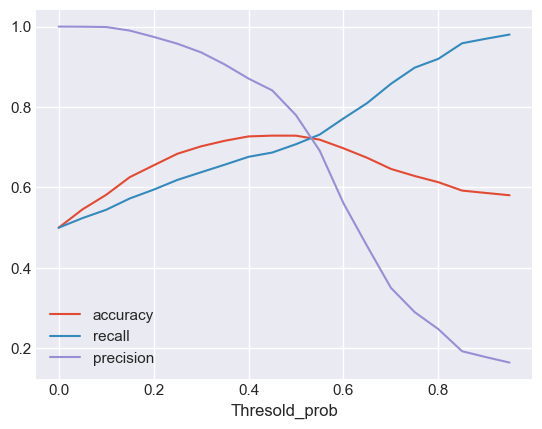

In [77]:
cutoff_df.plot.line(x='Thresold_prob', y=['accuracy','recall','precision'])
plt.show()

In [78]:
y_train_pred_final['final_predicted'] = y_train_pred_final.y_Prob.map( lambda x: 1 if x > 0.50 else 0)
y_train_pred_final.head()

,y,y_Prob,predicted,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,final_predicted
155724,0,0.17,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
374019,0,0.05,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
532713,1,0.34,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
560147,1,0.71,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,1
752570,1,1.00,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [79]:
X_train_sm.drop('const', axis= 1, inplace= True)
X_test = X_test[X_train_sm.columns]
print(X_train_sm.shape)
print(X_test.shape)

(581509, 16)
(249219, 16)


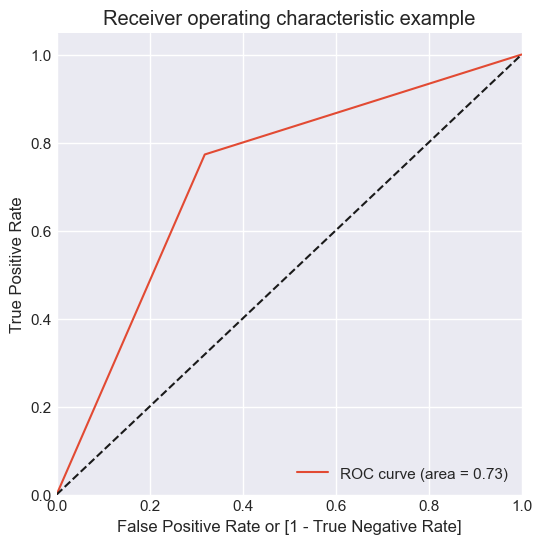

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy classifier,0.83,NaN,0.00,0.83,NaN,0.00,0.83,0.83,0.83,0.83,0.83,0.83
0,logistic regres - imbalance predict,0.93,0.85,0.71,0.93,0.85,0.71,0.93,0.93,0.93,0.93,0.93,0.93
0,logistic regres - balance predict,0.89,0.90,0.88,0.89,0.90,0.88,0.89,0.89,0.89,0.89,0.89,0.89
0,decision tree basic - imbalance predict,0.92,0.75,0.75,0.92,0.75,0.75,0.91,0.91,0.91,0.91,0.91,0.91
0,Random forest basic - imbalance predict,0.93,0.86,0.72,0.93,0.86,0.72,0.93,0.93,0.93,0.93,0.93,0.93
0,Random forest basic - balance predict,0.96,0.94,0.99,0.96,0.94,0.99,0.96,0.96,0.96,0.96,0.96,0.96
0,logistic reg with feature engine,0.73,0.71,0.77,0.73,0.71,0.77,0.73,0.73,0.73,0.73,0.73,0.73


In [80]:
model = LogisticRegression()
model.fit(X_train_sm, y_train)
accuracy, cnf_matrix = model_eval(model, X_test[X_train_sm.columns], y_test)
temp = store_results("logistic reg with feature engine", y_train, X_train_sm, y_test, X_test[X_train_sm.columns], \
                     model, 5)
draw_roc(model, X_test[X_train_sm.columns], y_test)
outcome = pd.concat([outcome, temp])
outcome

Decision tree model with feature engineering and balance predictor

In [81]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y_new, stratify= y_new, test_size= 0.3, random_state= 42)
X_train.head(2)

,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
155724,0,0.12,0.12,0.13,0.05,0.05,0.11,0.17,0.15,0.08,1,0,320,50,2351,3,163,61,3,30,12
374019,0,0.14,0.14,0.13,0.20,0.19,0.20,0.15,0.17,0.23,0,0,320,50,1752,3,297,82,4,24,13


In [82]:
dt_tree = DecisionTreeClassifier(random_state=42)
dt_tree.fit(X_train, y_train)
feature_importances = dt_tree.feature_importances_
features = X_train.columns
df = pd.DataFrame({'features': features, 'importance': feature_importances})
df.sort_values(by='importance', ascending = False)

,features,importance
8,device_ip,0.75
9,device_model,0.05
20,hour,0.05
7,device_id,0.04
1,site_id,0.02
19,day,0.02
18,dayofweek,0.02
14,C17,0.01
2,site_domain,0.01
17,C21,0.01


In [83]:
df = df[df.importance > 0.02]
rf_cols = []
for col in list(X_train.columns):
    if col in list(df.features):
        rf_cols.append(col)

In [84]:
dt_tree = DecisionTreeClassifier(random_state=42)
dt_tree.fit(X_train[rf_cols], y_train)

DecisionTreeClassifier(random_state=42)

['device_id', 'device_ip', 'device_model', 'hour']
4
Train results
accuracy 0.9744733099573696
cnf_matrix 
 [[279781  10973]
 [  3871 286884]]
Test results
accuracy 0.9463403673074685
cnf_matrix 
 [[114554  10056]
 [  3317 121292]]


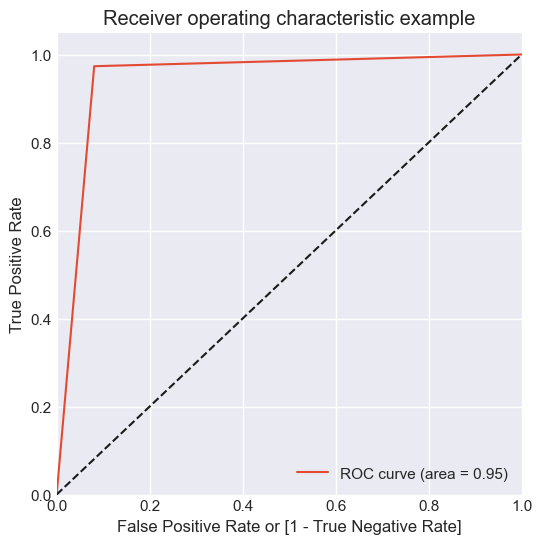

(array([0.        , 0.08069978, 1.        ]),
 array([0.        , 0.97338073, 1.        ]),
 array([inf,  1.,  0.]))

In [85]:
print(rf_cols)
X_train = X_train[rf_cols]
X_test = X_test[rf_cols]
print(len(rf_cols))
predict_rf = dt_tree.predict(X_train)
predict_rf_test = dt_tree.predict(X_test)

accuracy, cnf_matrix = model_eval(dt_tree, X_train, y_train)
print("Train results")
print("accuracy",accuracy)
print("cnf_matrix \n",cnf_matrix)

accuracy, cnf_matrix = model_eval(dt_tree, X_test, y_test)
print("Test results")
print("accuracy",accuracy)
print("cnf_matrix \n",cnf_matrix)

draw_roc(dt_tree, X_test, y_test)

Above basic tree with right features seems data is overfitting. having the correct hyper parameter tuning help in interpretation and bit of over fitting of the model.

In [86]:
param_grid = {
    'max_depth': range(1,15),
    'min_samples_leaf': range(10,200,20),
    'min_samples_split': range(50, 150, 50)
    
}
n_folds = 5
dtree = DecisionTreeClassifier(random_state= 42)
tree3 = GridSearchCV(dtree, param_grid, cv=n_folds, n_jobs =-1,return_train_score=True)
tree3.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(1, 15),
                         'min_samples_leaf': range(10, 200, 20),
                         'min_samples_split': range(50, 150, 50)},
             return_train_score=True)

In [87]:
tree3.best_params_

{'max_depth': 14, 'min_samples_leaf': 10, 'min_samples_split': 50}

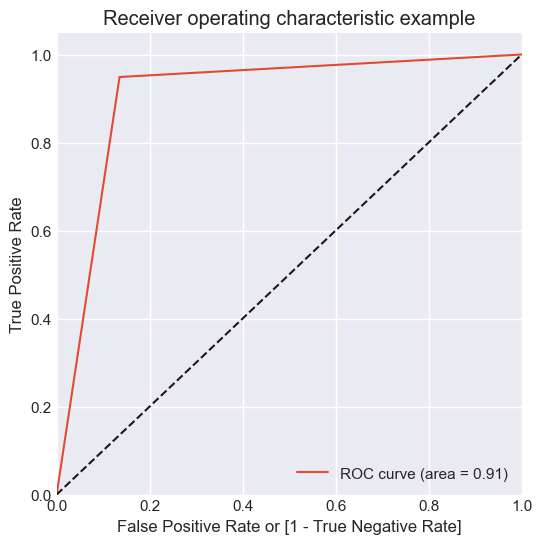

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy classifier,0.83,NaN,0.00,0.83,NaN,0.00,0.83,0.83,0.83,0.83,0.83,0.83
0,logistic regres - imbalance predict,0.93,0.85,0.71,0.93,0.85,0.71,0.93,0.93,0.93,0.93,0.93,0.93
0,logistic regres - balance predict,0.89,0.90,0.88,0.89,0.90,0.88,0.89,0.89,0.89,0.89,0.89,0.89
0,decision tree basic - imbalance predict,0.92,0.75,0.75,0.92,0.75,0.75,0.91,0.91,0.91,0.91,0.91,0.91
0,Random forest basic - imbalance predict,0.93,0.86,0.72,0.93,0.86,0.72,0.93,0.93,0.93,0.93,0.93,0.93
0,Random forest basic - balance predict,0.96,0.94,0.99,0.96,0.94,0.99,0.96,0.96,0.96,0.96,0.96,0.96
0,logistic reg with feature engine,0.73,0.71,0.77,0.73,0.71,0.77,0.73,0.73,0.73,0.73,0.73,0.73
0,Decision tree with feature engine,0.91,0.88,0.95,0.91,0.88,0.95,0.91,0.91,0.90,0.90,0.90,0.91


In [88]:
dt_tree =  DecisionTreeClassifier(max_depth=14, min_samples_leaf=10, min_samples_split=50,
                       random_state=42)
dt_tree.fit(X_train, y_train)
accuracy, cnf_matrix = model_eval(dt_tree, X_test, y_test)
temp = store_results("Decision tree with feature engine", y_train, X_train, y_test, X_test, \
                     dt_tree, 5)
draw_roc(dt_tree, X_test, y_test)
outcome = pd.concat([outcome, temp])
outcome

Random forest model with feature engineering and balance predictor.

In [89]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y_new, stratify= y_new, test_size= 0.3, random_state= 42)
X_train.head(2)

,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
155724,0,0.12,0.12,0.13,0.05,0.05,0.11,0.17,0.15,0.08,1,0,320,50,2351,3,163,61,3,30,12
374019,0,0.14,0.14,0.13,0.20,0.19,0.20,0.15,0.17,0.23,0,0,320,50,1752,3,297,82,4,24,13


In [90]:
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)
feature_importances = model_rf.feature_importances_
features = X_train.columns
df = pd.DataFrame({'features': features, 'importance': feature_importances})
df.sort_values(by='importance', ascending = False)

,features,importance
8,device_ip,0.64
7,device_id,0.07
9,device_model,0.07
20,hour,0.05
2,site_domain,0.03
1,site_id,0.03
4,app_id,0.02
19,day,0.01
18,dayofweek,0.01
14,C17,0.01


Using random forest feature importance metric to decide on best features and building the model.

['site_id', 'site_domain', 'app_id', 'device_id', 'device_ip', 'device_model', 'hour']
7
Train results
accuracy 0.9873879853966147
cnf_matrix 
 [[284843   5911]
 [  1423 289332]]
Test results
accuracy 0.9578764058920066
cnf_matrix 
 [[115859   8751]
 [  1747 122862]]


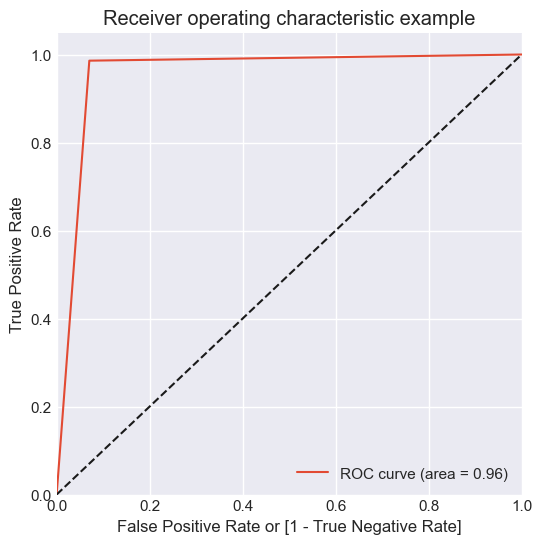

(array([0.        , 0.07022711, 1.        ]),
 array([0.        , 0.98598015, 1.        ]),
 array([inf,  1.,  0.]))

In [91]:
df = df[df.importance > 0.02]
rf_cols = []
for col in list(X_train.columns):
    if col in list(df.features):
        rf_cols.append(col)
        
X_train = X_train[rf_cols]
X_test = X_test[rf_cols]

model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)
print(rf_cols)

print(len(rf_cols))
predict_rf = model_rf.predict(X_train)
predict_rf_test = model_rf.predict(X_test)

accuracy, cnf_matrix = model_eval(model_rf, X_train, y_train)
print("Train results")
print("accuracy",accuracy)
print("cnf_matrix \n", cnf_matrix)

accuracy, cnf_matrix = model_eval(model_rf, X_test, y_test)
print("Test results")
print("accuracy",accuracy)
print("cnf_matrix \n", cnf_matrix)

draw_roc(model_rf, X_test, y_test)

In [92]:
temp = store_results("Random Forest with feature engine", y_train, X_train, y_test, X_test, \
                     model_rf, 5)
outcome = pd.concat([outcome, temp])

In [93]:
outcome.reset_index(drop=True, inplace=True)
outcome

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy classifier,0.83,NaN,0.00,0.83,NaN,0.00,0.83,0.83,0.83,0.83,0.83,0.83
1,logistic regres - imbalance predict,0.93,0.85,0.71,0.93,0.85,0.71,0.93,0.93,0.93,0.93,0.93,0.93
2,logistic regres - balance predict,0.89,0.90,0.88,0.89,0.90,0.88,0.89,0.89,0.89,0.89,0.89,0.89
3,decision tree basic - imbalance predict,0.92,0.75,0.75,0.92,0.75,0.75,0.91,0.91,0.91,0.91,0.91,0.91
4,Random forest basic - imbalance predict,0.93,0.86,0.72,0.93,0.86,0.72,0.93,0.93,0.93,0.93,0.93,0.93
5,Random forest basic - balance predict,0.96,0.94,0.99,0.96,0.94,0.99,0.96,0.96,0.96,0.96,0.96,0.96
6,logistic reg with feature engine,0.73,0.71,0.77,0.73,0.71,0.77,0.73,0.73,0.73,0.73,0.73,0.73
7,Decision tree with feature engine,0.91,0.88,0.95,0.91,0.88,0.95,0.91,0.91,0.90,0.90,0.90,0.91
8,Random Forest with feature engine,0.96,0.93,0.99,0.96,0.93,0.99,0.95,0.95,0.95,0.95,0.95,0.95


Conclusion : 

If we have to select one model, Random forest classifier with feature enginnering looks promising and best. although after the feature engineering the training and test results looks same as before feature engineering, but model is very robust with new features and rightly fitted for both training and test dataset. 

Decisiontree and logistic regression classifer seems to have low accuracy, precision, and recall, overall random forest classifier seems doing better with all aspects.


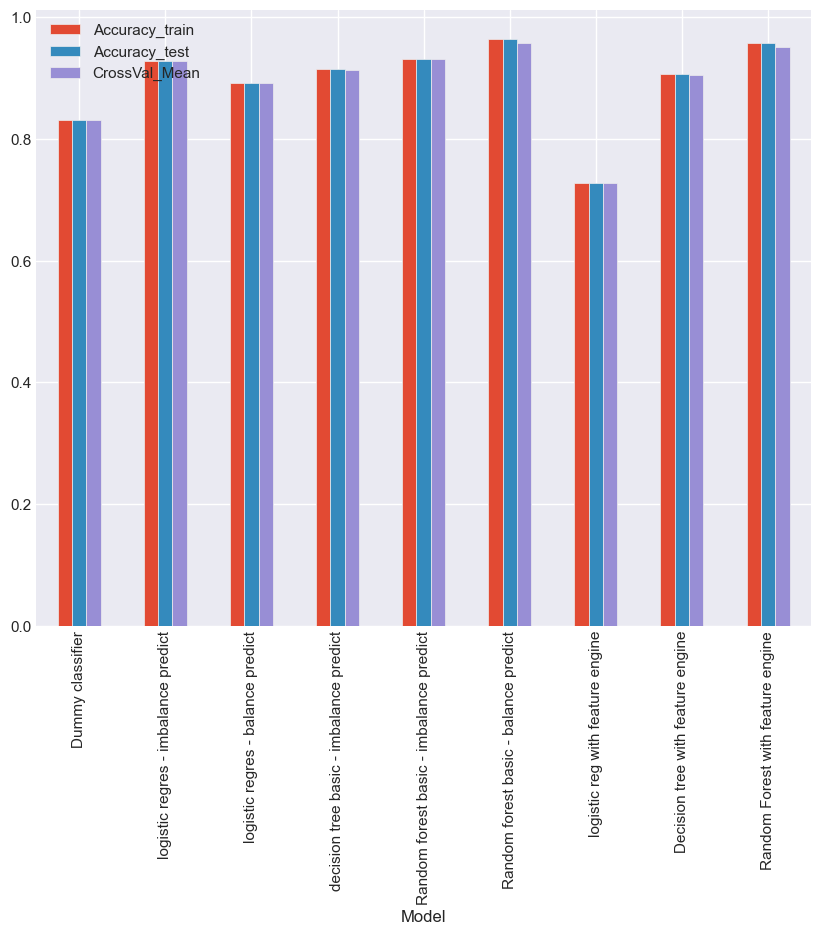

In [94]:
plt.rcParams["figure.figsize"] = (10,8)
outcome.plot(x='Model', y=['Accuracy_train','Accuracy_test','CrossVal_Mean'], kind="bar")
plt.xticks(rotation=90)
plt.show()

In [95]:
test['month'] = test['hour'].dt.month
test['dayofweek'] = test['hour'].dt.dayofweek
test['day'] = test['hour'].dt.day
test['hour_time'] = test['hour'].dt.hour
test.head(2)

,id,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,month,dayofweek,day,hour_time
0,10001094637809798845,2014-10-31,1005,0,85f751fd,c4e18dd6,50e219e0,51cedd4e,aefc06bd,0f2161f8,a99f214a,422d257a,542422a7,1,0,18648,320,50,1092,3,809,100156,61,10,4,31,0
1,10001377041558670745,2014-10-31,1005,0,85f751fd,c4e18dd6,50e219e0,9c13b419,2347f47a,f95efa07,a99f214a,078c6b38,1f0bc64f,1,0,23160,320,50,2667,0,47,-1,221,10,4,31,0


In [96]:
col = ['C15', 'C16', 'C19', 'C21']
for col in col:
    percentiles = test[col].quantile(0.98)
    if test[col].quantile(0.98) < 0.5 * test[col].max():
        test[col][test[col] >= percentiles] = percentiles

In [97]:
test.drop(['id', 'hour'], axis = 1, inplace = True) 
test.rename(columns={'hour_time': 'hour'},
          inplace=True, errors='raise')
test.columns

Index(['C1', 'banner_pos', 'site_id', 'site_domain', 'site_category', 'app_id',
       'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model',
       'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18',
       'C19', 'C20', 'C21', 'month', 'dayofweek', 'day', 'hour'],
      dtype='object')

In [98]:
test.drop(['month', 'C20'], axis=1, inplace=True)
test.drop(['C14', 'C1'], axis=1, inplace= True)

In [99]:
test =  target_encoder.transform(test)
test.head(2)

,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
0,0,0.12,0.12,0.13,0.05,0.07,0.11,0.17,0.17,0.06,1,0,320,50,1092,3,809,61,4,31,0
1,0,0.12,0.12,0.13,0.31,0.14,0.25,0.17,0.17,0.22,1,0,320,50,2667,0,47,221,4,31,0


In [100]:
test[test.columns]  = scaler.transform(test[test.columns])
test.head(2)

,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
0,0.00,0.15,0.18,0.21,0.05,0.12,0.37,0.21,0.25,0.10,0.20,0.00,1.00,0.13,0.37,1.00,0.43,0.24,0.67,1.11,0.00
1,0.00,0.15,0.18,0.21,0.32,0.24,1.00,0.21,0.25,0.36,0.20,0.00,1.00,0.13,0.97,0.00,0.01,0.87,0.67,1.11,0.00


In [101]:
# random forest with balanced data was our best model, hence using the same for submission.
rf_cols

['site_id',
 'site_domain',
 'app_id',
 'device_id',
 'device_ip',
 'device_model',
 'hour']

In [102]:
test = test[rf_cols]
predict_sub = model_rf.predict(test)
print(len(predict_sub))
print(print(len(submission)))
print(predict_sub)

564540
4577464
None
[1 1 1 ... 1 1 1]


Preparing test data for sumbission

In [103]:
# submission['click'] = predict_sub
# submission.head(2)

ValueError: Length of values (564540) does not match length of index (4577464)

In [ ]:
# submission.to_csv('submission.csv', index = False)